In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import copy
import numpy as np
import matplotlib.pyplot as plt
from ptflops import get_model_complexity_info
from models import UnlabelledJetDataset, VAE

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset (consistent with previous notebooks)
unlabelled_dataset = UnlabelledJetDataset('../Dataset_Specific_Unlabelled.h5')
unlabelled_loader = DataLoader(unlabelled_dataset, batch_size=64, shuffle=True, num_workers=4)

# Load pre-trained baseline VAE
vae = VAE(latent_dim=128).to(device)

def load_model(model, path):
    state_dict = torch.load(path, map_location=device)
    new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict)

try:
    load_model(vae, './res/best/best_vae.pth')
    print("Baseline VAE loaded successfully")
except FileNotFoundError as e:
    print(f"Error: Model file not found - {e}")
except RuntimeError as e:
    print(f"Error loading state dict: {e}")

Using device: cuda
Baseline VAE loaded successfully


In [2]:
# ---------------------------
# Loss Function for Sparse Autoencoder
# ---------------------------
def sparse_loss(recon, x, latent, sparsity_weight=1e-3):
    recon_loss = F.mse_loss(recon, x, reduction='sum')
    l1_penalty = sparsity_weight * torch.sum(torch.abs(latent))
    return recon_loss + l1_penalty

# ---------------------------
# Training Function for Sparse Autoencoder
# ---------------------------
def train_sparse_autoencoder(model, dataloader, optimizer, device, epoch, sparsity_weight=1e-3):
    model.train()
    total_loss = 0.0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon, latent = model(batch)
        loss = sparse_loss(recon, batch, latent, sparsity_weight)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch {epoch+1}: Sparse AE Loss = {avg_loss:.4f}")
    return avg_loss

# ---------------------------
# Evaluation Function for Sparse AE: Reconstruction Error (MSE per sample)
# ---------------------------
def evaluate_reconstruction_sparse(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            recon, latent = model(batch)
            loss = F.mse_loss(recon, batch, reduction='sum')
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss

In [3]:
# ---------------------------
# Define Sparse Autoencoder Architecture
# ---------------------------
class SparseAutoencoder(nn.Module):
    def __init__(self, input_shape=(8, 128, 128), latent_dim=128):
        super(SparseAutoencoder, self).__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim

        # Encoder (similar to baseline VAE encoder)
        self.encoder = nn.Sequential(
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Flatten()
        )

        self.fc_enc = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.fc_latent = nn.Linear(256, latent_dim)

        # Decoder (similar to baseline VAE decoder)
        self.decoder_input = nn.Linear(latent_dim, 128 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def encode(self, x):
        h = self.encoder(x)
        h = self.fc_enc(h)
        latent = self.fc_latent(h)
        return latent

    def decode(self, z):
        h = F.leaky_relu(self.decoder_input(z), 0.2)
        h = h.view(-1, 128, 8, 8)
        x_recon = self.decoder(h)
        return x_recon

    def forward(self, x):
        latent = self.encode(x)
        x_recon = self.decode(latent)
        return x_recon, latent

In [5]:
# ---------------------------
# Benchmarking: Compare Baseline VAE vs Sparse AE
# ---------------------------
# Evaluate baseline VAE
baseline_recon_error = 0.0
vae.eval()
with torch.no_grad():
    for batch in unlabelled_loader:
        batch = batch.to(device)
        recon, mu, logvar = vae(batch)
        loss = F.mse_loss(recon, batch, reduction='sum')
        baseline_recon_error += loss.item()
baseline_recon_error /= len(unlabelled_loader.dataset)
baseline_flops, _ = get_model_complexity_info(vae, (8, 128, 128), as_strings=False)
print(f"Baseline VAE: Recon Error = {baseline_recon_error:.4f}, FLOPS = {baseline_flops:.2e}")

# Train Sparse Autoencoder for different sparsity weights
sparsity_weights = [0.0, 1e-4, 1e-3, 1e-2, 1e-1]  # 0.0 means no L1 penalty (like baseline)
sparse_results = []

for sw in sparsity_weights:
    print(f"\nTraining Sparse AE with sparsity weight λ = {sw}")
    sparse_ae = SparseAutoencoder(latent_dim=128).to(device)
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs for Sparse AE training")
        sparse_ae = nn.DataParallel(sparse_ae)
    optimizer_sa = optim.Adam(sparse_ae.parameters(), lr=1e-3)
    num_epochs = 30
    best_loss = float('inf')
    patience = 3
    patience_counter = 0
    for epoch in range(num_epochs):
        epoch_loss = train_sparse_autoencoder(sparse_ae, unlabelled_loader, optimizer_sa, device, epoch, sparsity_weight=sw)
        improvement = best_loss - epoch_loss
        if improvement > 1.0:
            best_loss = epoch_loss
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} for sparsity weight λ = {sw}")
            break
    if isinstance(sparse_ae, nn.DataParallel):
        recon_error_sa = evaluate_reconstruction_sparse(sparse_ae.module, unlabelled_loader, device)
        flops_sa, _ = get_model_complexity_info(sparse_ae.module, (8, 128, 128), as_strings=False)
    else:
        recon_error_sa = evaluate_reconstruction_sparse(sparse_ae, unlabelled_loader, device)
        flops_sa, _ = get_model_complexity_info(sparse_ae, (8, 128, 128), as_strings=False)
    sparse_results.append((sw, recon_error_sa, flops_sa))
    print(f"Sparse AE (λ = {sw}): Recon Error = {recon_error_sa:.4f}, FLOPS = {flops_sa:.2e}")

VAE(
  3.42 M, 100.000% Params, 98.67 MMac, 100.000% MACs, 
  (encoder): Sequential(
    98.64 k, 2.887% Params, 19.37 MMac, 19.626% MACs, 
    (0): Conv2d(1.17 k, 0.034% Params, 4.78 MMac, 4.848% MACs, 8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, 0.001% Params, 131.07 KMac, 0.133% MACs, 16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(0, 0.000% Params, 65.54 KMac, 0.066% MACs, negative_slope=0.2)
    (3): Conv2d(4.64 k, 0.136% Params, 4.75 MMac, 4.815% MACs, 16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, 0.002% Params, 65.54 KMac, 0.066% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(0, 0.000% Params, 32.77 KMac, 0.033% MACs, negative_slope=0.2)
    (6): Conv2d(18.5 k, 0.541% Params, 4.73 MMac, 4.799% MACs, 32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, 0.004% Params, 32.77 KMac, 0.033% MACs

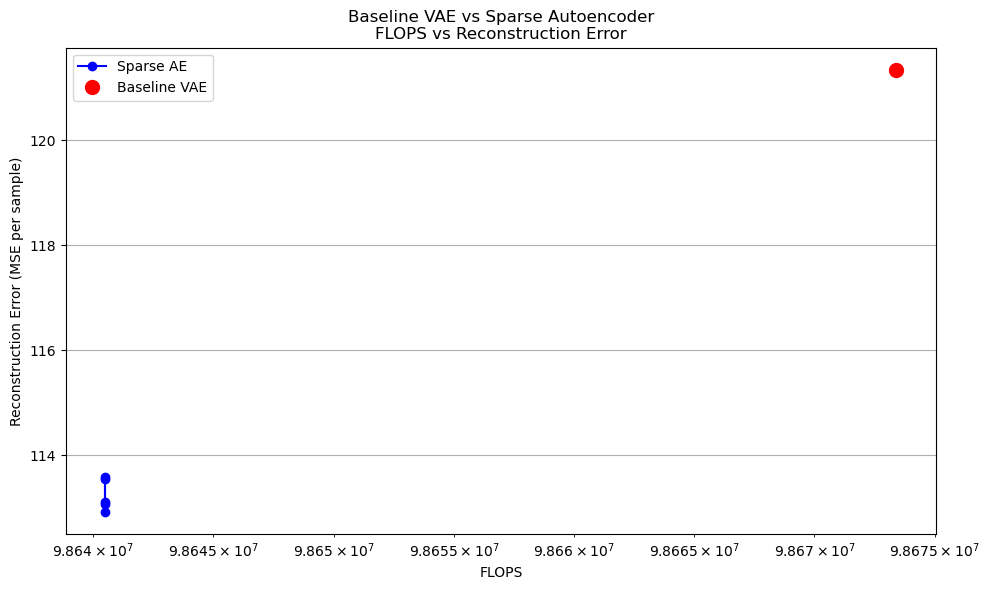

Sparse Autoencoder model saved to ./res/sparse_ae_model.pth


In [6]:
# ---------------------------
# Plot: FLOPS vs Reconstruction Error
# ---------------------------
flops_sparse = [res[2] for res in sparse_results]
errors_sparse = [res[1] for res in sparse_results]
sparsity_labels = [f"λ={res[0]}" for res in sparse_results]

plt.figure(figsize=(10, 6))
plt.plot(flops_sparse, errors_sparse, 'bo-', label='Sparse AE')
plt.plot([baseline_flops], [baseline_recon_error], 'ro', label='Baseline VAE', markersize=10)
plt.xlabel('FLOPS')
plt.ylabel('Reconstruction Error (MSE per sample)')
plt.title('Baseline VAE vs Sparse Autoencoder\nFLOPS vs Reconstruction Error')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.tight_layout()
plt.show()

# Save the final sparse autoencoder model
model_to_save = sparse_ae.module if isinstance(sparse_ae, nn.DataParallel) else sparse_ae
torch.save(model_to_save.state_dict(), "./res/sparse_ae_model.pth")
print("Sparse Autoencoder model saved to ./res/sparse_ae_model.pth")